In [1]:
import numpy as np
import scipy
from scipy.stats import multivariate_normal
from scipy import linalg

import copy
import matplotlib.pyplot as plt 
import matplotlib.image as img
from PIL import Image, ImageStat
import kmeans2 #kmeans

%matplotlib inline

In [2]:
# load image
im = Image.open("hw3_img.jpg", 'r')
img_width, img_height = im.size
px = im.load()

img_arr = []
for x in range(0, img_width):
    for y in range(0, img_height):
        pi = px[x, y]
        img_arr.append(list(pi))

img_arr = np.array(img_arr)
img_arr2 = img_arr/255

In [3]:
def findLikeRes(img_array, weights, means, covariances, K): 
   
    # find responsibility and likelihood
    res = np.zeros((len(img_array), K)) # rik
    
    for k in range(K):
        res[:, k] = weights[k] * multivariate_normal.pdf(img_array, mean = means[k], cov = covariances[k])
    
    log_likelihood = np.sum(np.log(np.sum(res, axis=1)))
    log_likelihood = log_likelihood/len(img_array)
    
    res_all = res.sum(axis = 1)[:, np.newaxis]
    
    res = res / res_all
    
    return log_likelihood, res

In [4]:
def EM(img_array, K_mean_points, covariances, mixcoefficient, iteration = 100, thresh=1e-4):
    
    # initialization
    K = len(K_mean_points)
    
    means = K_mean_points
    mixcoefficient
    weights = mixcoefficient # weights is Mixing coefficient
    
    nums, dim = img_array.shape[0], img_array.shape[-1] # img
    
    prob_list = []    
    prob, res = findLikeRes(img_array, weights, means, covariances, K)
    prob_list.append(prob)
    
    res = np.zeros((nums, K))
    
    for it in range(iteration):
        
        # E res
        new_prob, res = findLikeRes(img_array, weights, means, covariances, K)

        # M-step
        softcounts =  np.sum(res, axis = 0)
        weights = softcounts *1.0 / nums # update weights
         
        rel_x_sum = np.dot(res.T, img_array)        
        cov_rel_sum = np.zeros((dim , dim))
       
        for k in range(K):
            means[k] = rel_x_sum[k] *1.0 / softcounts[k]
            mean = means[k] # update means
            diff = img_array - mean # X-u
            post_res = res[:, k]
            
            with np.errstate(under='ignore'):
                m_cv = np.dot(post_res * diff.T, diff) / (post_res.sum()) # res *(X-u)(X-u).T
            
            covariances[k] = m_cv + 1e-7 * np.eye(dim) # update cov with minivalue 
        
        # add
        prob_list.append(new_prob)
        
        prob = new_prob
        if it % 5 == 0 or it==iteration-1:
            print("Iteration %s probability %.3f" % (it,prob) )
    
    out = {'weights': weights, 'means': means, 'covs': covariances, 'loglik': prob_list, 'resp': res}

    return out

In [5]:
def draw(img_array, img_width, img_height, means, predict, K):

    cp_imgarr = copy.deepcopy(img_array)
    img = Image.new('RGB', (img_width, img_height), "white")
    p = img.load()
    
    argp = np.argmax(predict, axis = 1)
    for i in range(len(argp)):
        RGB_value =  means[argp[i]]*255
        cp_imgarr[i] = RGB_value

    i = 0
    for x in range(img_width):
        for y in range(img_height):
            p[x, y] = tuple(cp_imgarr[i].astype(int))
            i+=1 
    img.show()
    img.save('EM_'+str(K)+'_poblem3.jpg')

****************************************************************************************************
centroids table:10
[45, 33, 6]
[224, 226, 210]
[217, 61, 10]
[107, 95, 27]
[92, 43, 10]
[206, 187, 149]
[15, 8, 2]
[90, 131, 163]
[225, 184, 50]
[155, 135, 73]
****************************************************************************************************
cov
[[[ 0.00174446  0.00061397 -0.00018547]
  [ 0.00061397  0.0018038   0.00088984]
  [-0.00018547  0.00088984  0.00257768]]

 [[ 0.00645081  0.00033018 -0.00069724]
  [ 0.00033018  0.00270996  0.00286997]
  [-0.00069724  0.00286997  0.00489809]]

 [[ 0.00872706  0.00211764  0.00031829]
  [ 0.00211764  0.00409395  0.00269591]
  [ 0.00031829  0.00269591  0.00320908]]

 [[ 0.00518907  0.00197676 -0.00064876]
  [ 0.00197676  0.0040252  -0.00096377]
  [-0.00064876 -0.00096377  0.00715062]]

 [[ 0.00749501 -0.00249404 -0.00108528]
  [-0.00249404  0.0044803   0.00150128]
  [-0.00108528  0.00150128  0.0022251 ]]

 [[ 0.00748917  0.001861

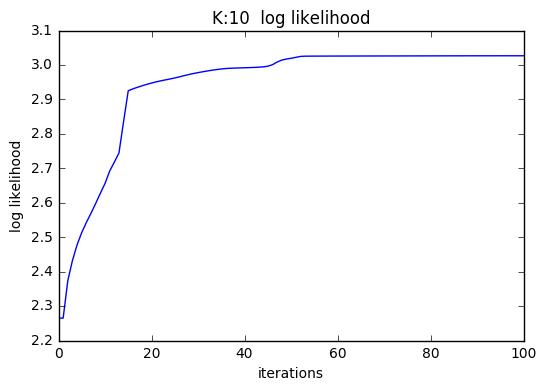

In [6]:
# run kmeans
K = 10
kmodel = kmeans2.Kmeans(K, img_width, img_height, img_arr2, iteration = 20)
kmodel.runs()
kmodel.kmeanDraw()
print('*'*100)
print('centroids table:'+str(K))
for i in kmodel.centroids:
    i = i*255
    print(list(i.astype(int)))
print('*'*100)
print('cov')
print(kmodel.cov)
print('*'*100)
print('mix coeff')
print(kmodel.mixcoef)
print('*'*100)
out_dict = EM(img_arr2, kmodel.centroids, kmodel.cov, kmodel.mixcoef)

_, predict = findLikeRes(img_arr2, out_dict['weights'], out_dict['means'], out_dict['covs'], K) 
draw(img_arr2, img_width, img_height, out_dict['means'], predict, K)

plt.title("K:" +str(K)+"  log likelihood" )
plt.plot(out_dict['loglik'])
plt.xlabel("iterations")
plt.ylabel("log likelihood")
plt.show()

****************************************************************************************************
centroids table:2
[77, 46, 12]
[205, 184, 125]
****************************************************************************************************
cov
[[[ 0.06161059  0.02103716  0.00338153]
  [ 0.02103716  0.01940218  0.00685054]
  [ 0.00338153  0.00685054  0.00771528]]

 [[ 0.02177045  0.01104775 -0.00142081]
  [ 0.01104775  0.02203107  0.0203312 ]
  [-0.00142081  0.0203312   0.06797279]]]
****************************************************************************************************
mix coeff
[0.5015766059027778, 0.49842339409722225]
****************************************************************************************************
Iteration 0 probability 1.116
Iteration 5 probability 1.372
Iteration 10 probability 1.448
Iteration 15 probability 1.454
Iteration 20 probability 1.455
Iteration 25 probability 1.455
Iteration 30 probability 1.455
Iteration 35 probability 1.455
Ite

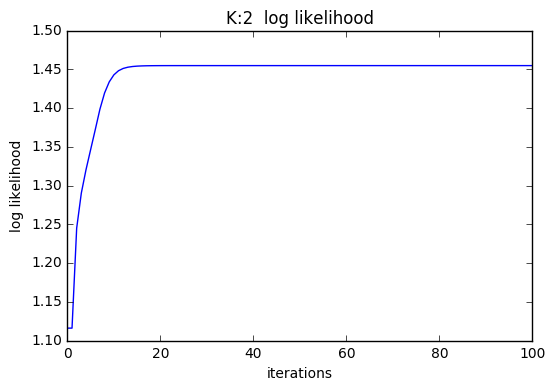

In [7]:
# run kmeans
K = 2
kmodel = kmeans2.Kmeans(K, img_width, img_height, img_arr2, iteration = 20)
kmodel.runs()
kmodel.kmeanDraw()
print('*'*100)
print('centroids table:'+str(K))
for i in kmodel.centroids:
    i = i*255
    print(list(i.astype(int)))
print('*'*100)
print('cov')
print(kmodel.cov)
print('*'*100)
print('mix coeff')
print(kmodel.mixcoef)
print('*'*100)
out_dict = EM(img_arr2, kmodel.centroids, kmodel.cov, kmodel.mixcoef)

_, predict = findLikeRes(img_arr2, out_dict['weights'], out_dict['means'], out_dict['covs'], K) 
draw(img_arr2, img_width, img_height, out_dict['means'], predict, K)

plt.title("K:" +str(K)+"  log likelihood" )
plt.plot(out_dict['loglik'])
plt.xlabel("iterations")
plt.ylabel("log likelihood")
plt.show()

****************************************************************************************************
centroids table:3
[190, 135, 47]
[207, 201, 176]
[50, 34, 9]
****************************************************************************************************
cov
[[[ 0.03061498  0.00902812 -0.00666839]
  [ 0.00902812  0.03928954  0.0097188 ]
  [-0.00666839  0.0097188   0.01738562]]

 [[ 0.02215886  0.01131917  0.00028904]
  [ 0.01131917  0.01238252  0.00868233]
  [ 0.00028904  0.00868233  0.02046557]]

 [[ 0.02037455  0.01129317  0.00260189]
  [ 0.01129317  0.01207241  0.00413525]
  [ 0.00260189  0.00413525  0.00520313]]]
****************************************************************************************************
mix coeff
[0.3328993055555556, 0.28070529513888887, 0.38639539930555555]
****************************************************************************************************
Iteration 0 probability 1.442
Iteration 5 probability 1.736
Iteration 10 probability 1.797
I

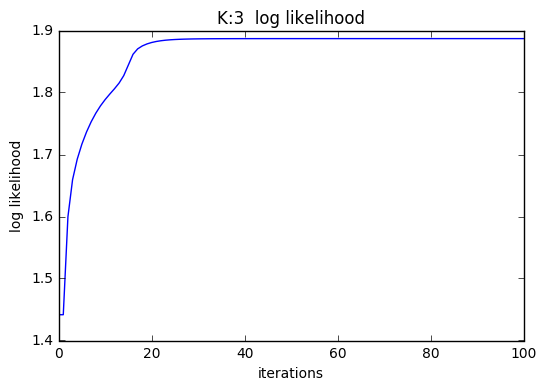

In [8]:
# run kmeans
K = 3
kmodel = kmeans2.Kmeans(K, img_width, img_height, img_arr2, iteration = 20)
kmodel.runs()
kmodel.kmeanDraw()
print('*'*100)
print('centroids table:'+str(K))
for i in kmodel.centroids:
    i = i*255
    print(list(i.astype(int)))
print('*'*100)
print('cov')
print(kmodel.cov)
print('*'*100)
print('mix coeff')
print(kmodel.mixcoef)
print('*'*100)
out_dict = EM(img_arr2, kmodel.centroids, kmodel.cov, kmodel.mixcoef)

_, predict = findLikeRes(img_arr2, out_dict['weights'], out_dict['means'], out_dict['covs'], K) 
draw(img_arr2, img_width, img_height, out_dict['means'], predict, K)

plt.title("K:" +str(K)+"  log likelihood" )
plt.plot(out_dict['loglik'])
plt.xlabel("iterations")
plt.ylabel("log likelihood")
plt.show()

****************************************************************************************************
centroids table:5
[216, 178, 61]
[115, 105, 54]
[38, 23, 5]
[211, 204, 180]
[209, 58, 9]
****************************************************************************************************
cov
[[[ 0.00997722  0.00560844 -0.00344462]
  [ 0.00560844  0.01383064 -0.00305367]
  [-0.00344462 -0.00305367  0.01472944]]

 [[ 0.0139298   0.0061764  -0.00414479]
  [ 0.0061764   0.0092292   0.00698768]
  [-0.00414479  0.00698768  0.03511864]]

 [[ 0.01138537  0.00523239  0.00068497]
  [ 0.00523239  0.00464049  0.00115428]
  [ 0.00068497  0.00115428  0.00162327]]

 [[ 0.0112565   0.00545723  0.00312682]
  [ 0.00545723  0.00898727  0.00987461]
  [ 0.00312682  0.00987461  0.01666018]]

 [[ 0.01521664  0.00461292  0.00038094]
  [ 0.00461292  0.00517262  0.00237339]
  [ 0.00038094  0.00237339  0.00266452]]]
***********************************************************************************************

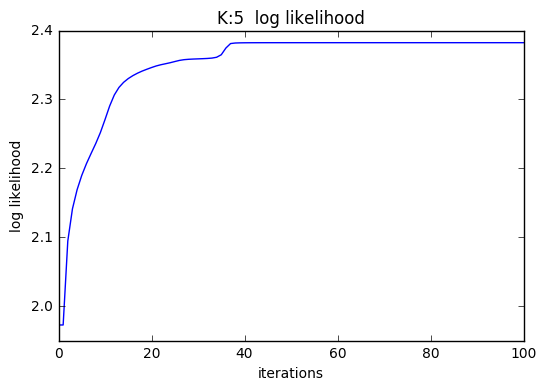

In [9]:
# run kmeans
K = 5
kmodel = kmeans2.Kmeans(K, img_width, img_height, img_arr2, iteration = 20)
kmodel.runs()
kmodel.kmeanDraw()
print('*'*100)
print('centroids table:'+str(K))
for i in kmodel.centroids:
    i = i*255
    print(list(i.astype(int)))
print('*'*100)
print('cov')
print(kmodel.cov)
print('*'*100)
print('mix coeff')
print(kmodel.mixcoef)
print('*'*100)
out_dict = EM(img_arr2, kmodel.centroids, kmodel.cov, kmodel.mixcoef)

_, predict = findLikeRes(img_arr2, out_dict['weights'], out_dict['means'], out_dict['covs'], K) 
draw(img_arr2, img_width, img_height, out_dict['means'], predict, K)

plt.title("K:" +str(K)+"  log likelihood" )
plt.plot(out_dict['loglik'])
plt.xlabel("iterations")
plt.ylabel("log likelihood")
plt.show()

****************************************************************************************************
centroids table:20
[214, 171, 74]
[236, 206, 38]
[22, 12, 1]
[91, 78, 20]
[141, 34, 7]
[86, 131, 172]
[190, 60, 14]
[55, 43, 9]
[226, 230, 215]
[209, 181, 132]
[227, 123, 59]
[123, 109, 25]
[38, 27, 4]
[230, 61, 6]
[206, 196, 171]
[102, 97, 75]
[181, 158, 36]
[5, 3, 2]
[88, 37, 5]
[152, 136, 88]
****************************************************************************************************
cov
[[[  2.31632877e-03  -5.29074225e-05  -5.79677845e-04]
  [ -5.29074225e-05   3.35237429e-03   2.49958389e-04]
  [ -5.79677845e-04   2.49958389e-04   4.13624015e-03]]

 [[  3.37947967e-03   2.20974401e-03   4.93975063e-04]
  [  2.20974401e-03   7.66744388e-03   3.67764015e-03]
  [  4.93975063e-04   3.67764015e-03   4.98657754e-03]]

 [[  6.03325947e-04  -3.76770495e-05  -7.60333969e-05]
  [ -3.76770495e-05   4.59135434e-04   1.45724996e-04]
  [ -7.60333969e-05   1.45724996e-04   3.19106423e-04

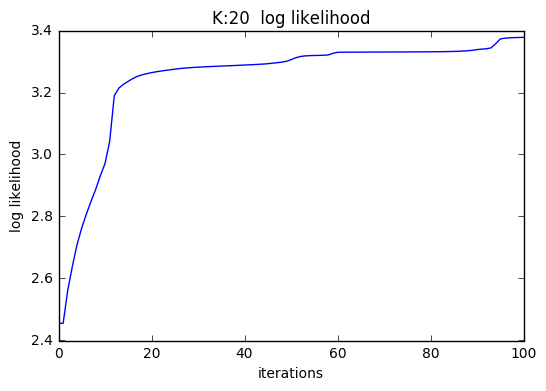

In [10]:
# run kmeans
K = 20
kmodel = kmeans2.Kmeans(K, img_width, img_height, img_arr2, iteration = 20)
kmodel.runs()
kmodel.kmeanDraw()
print('*'*100)
print('centroids table:'+str(K))
for i in kmodel.centroids:
    i = i*255
    print(list(i.astype(int)))
print('*'*100)
print('cov')
print(kmodel.cov)
print('*'*100)
print('mix coeff')
print(kmodel.mixcoef)
print('*'*100)
out_dict = EM(img_arr2, kmodel.centroids, kmodel.cov, kmodel.mixcoef)

_, predict = findLikeRes(img_arr2, out_dict['weights'], out_dict['means'], out_dict['covs'], K) 
draw(img_arr2, img_width, img_height, out_dict['means'], predict, K)

plt.title("K:" +str(K)+"  log likelihood" )
plt.plot(out_dict['loglik'])
plt.xlabel("iterations")
plt.ylabel("log likelihood")
plt.show()

# Report

From the loglikelihood, we can infer bigger K will get higher likelihood at the beginning, but getting slower convergence for EM, because EM can let loglikelihood get higher when K is bigger.